# 3. FUNDAMENTOS DE ESTADÍSTICA

En este notebook exploraremos los conceptos fundamentales de la estadística y cómo aplicarlos en Python con ejemplos prácticos.

## 3.1 Estadística Descriptiva
La estadística descriptiva resume y organiza datos en medidas y visualizaciones.

**Medidas importantes:**
- Media, Mediana, Moda
- Varianza, Desviación estándar
- Rango, Cuartiles

          Valores
count  100.000000
mean    49.053681
std     10.242187
min     20.028173
25%     41.648508
50%     51.186134
75%     56.820614
max     72.253727


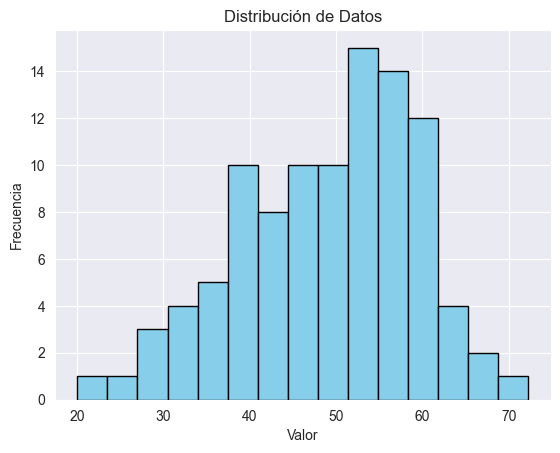

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Crear un conjunto de datos simulado
data = np.random.normal(loc=50, scale=10, size=100)
df = pd.DataFrame(data, columns=['Valores'])

# Estadísticos descriptivos
print(df.describe())

# Visualización
plt.hist(df['Valores'], bins=15, color='skyblue', edgecolor='black')
plt.title('Distribución de Datos')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

## 3.2 Estadística por Inferencias
La estadística inferencial permite generalizar conclusiones sobre una población a partir de una muestra.

Ejemplo: prueba de hipótesis sobre la media poblacional usando una muestra.

In [2]:
from scipy import stats

# Prueba t de una muestra
t_stat, p_value = stats.ttest_1samp(df['Valores'], popmean=50)
print(f"Estadístico t: {t_stat}, p-valor: {p_value}")

if p_value < 0.05:
    print("Rechazamos la hipótesis nula: la media es significativamente diferente de 50")
else:
    print("No se puede rechazar la hipótesis nula: la media no difiere significativamente de 50")

Estadístico t: -0.9239419317849332, p-valor: 0.35776307077253533
No se puede rechazar la hipótesis nula: la media no difiere significativamente de 50


## 3.3 Diseño de experimentos y comprobación de hipótesis
Se diseñan experimentos para probar hipótesis.
- Hipótesis nula (H0)
- Hipótesis alternativa (H1)
- Nivel de significancia (α)
- Estadístico de prueba
- Decisión basada en p-valor

In [3]:
# Simulación de dos grupos de datos
grupo_A = np.random.normal(52, 8, 50)
grupo_B = np.random.normal(49, 8, 50)

# Prueba t para dos muestras independientes
t_stat, p_value = stats.ttest_ind(grupo_A, grupo_B)
print(f"Estadístico t: {t_stat}, p-valor: {p_value}")

if p_value < 0.05:
    print("Las medias de los dos grupos son significativamente diferentes")
else:
    print("No hay evidencia significativa de diferencia entre los grupos")

Estadístico t: 1.866455916175673, p-valor: 0.06496761444980029
No hay evidencia significativa de diferencia entre los grupos


## 3.4 Modelado de datos
El modelado estadístico busca describir relaciones entre variables. Ejemplo: regresión lineal simple.

Pendiente: 2.8740139097326, Intercepto: 1.032702420348464


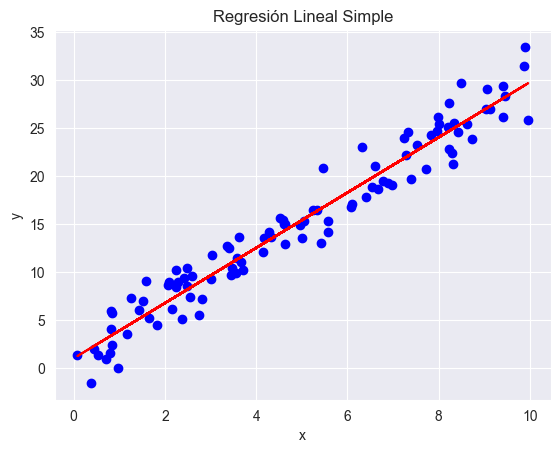

In [4]:
from sklearn.linear_model import LinearRegression

# Datos simulados
x = np.random.rand(100, 1) * 10
y = 3*x + np.random.randn(100, 1) * 2

# Modelo
model = LinearRegression()
model.fit(x, y)

print(f"Pendiente: {model.coef_[0][0]}, Intercepto: {model.intercept_[0]}")

# Visualización
plt.scatter(x, y, color='blue')
plt.plot(x, model.predict(x), color='red')
plt.title('Regresión Lineal Simple')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 3.5 Utilizar las estadísticas en problemas sociales del mundo real
Ejemplo: analizar datos de ingresos y educación en una población para estudiar desigualdades.

                   Años de Educación  Ingresos
Años de Educación           1.000000  0.878097
Ingresos                    0.878097  1.000000


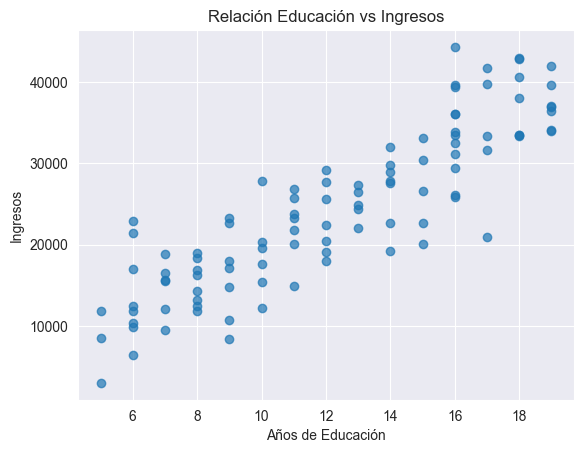

In [5]:
# Simulación de datos socioeconómicos
np.random.seed(42)
educacion = np.random.randint(5, 20, 100)
ingresos = educacion * 2000 + np.random.normal(0, 5000, 100)

df_soc = pd.DataFrame({'Años de Educación': educacion, 'Ingresos': ingresos})

print(df_soc.corr())

# Visualización
plt.scatter(df_soc['Años de Educación'], df_soc['Ingresos'], alpha=0.7)
plt.title('Relación Educación vs Ingresos')
plt.xlabel('Años de Educación')
plt.ylabel('Ingresos')
plt.show()